In [4]:
# Basics
import pandas as pd
import numpy as np

#  Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

# Tests
from statsmodels.stats.diagnostic import lilliefors #Kolmogorov-Smirnov normality test
import scipy.stats as scs # QQ plot
from statsmodels.compat import lzip # Homocedascity test
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.stats.stattools import durbin_watson

In [5]:
data_ = sklearn.datasets.load_wine()
# Create dataframe
df = pd.DataFrame(data_.data, columns=data_.feature_names)
df['target'] = data_.target
df.rename(columns={'od280/od315_of_diluted_wines': 'test_diluted_wines'}, inplace=True)

### Linear Regression
The Ordinary Least Squares (OLS) method is the most common for LR and, in short, it tries to draw a line somewhere between the points that will give us the best fit, that will give us the lowest number when we sum the difference between the real values to the regression line.

That difference is the error component of the famous equation y = a + bx + e. The OLS method will square those errors and sum the amounts, trying to reach the minimum number as the result, which will result in the coefficients for the equation with the best fit.

assumptions where we should test the residuals of a LR:

- The residuals must follow a normal distribution.
- The residuals are homogeneous, there’s homoscedasticity.
- There’s no outliers in the errors.
- There’s no autocorrelation in the errors.
- There’s no multicolinearity between the independent variables.


#### The Errors Must Follow a Normal Distribution
When we’re creating a LR model, sometimes we hear that the variables must follow a normal distribution. That is not quite true. What must follow such distribution is the residuals.

In [6]:
# Regression Model
model = smf.ols('target ~ alcohol + ash + alcalinity_of_ash + total_phenols + flavanoids + nonflavanoid_phenols + color_intensity + hue + test_diluted_wines + proline', data = df).fit()
# Extract the residuals
model_resid = model.resid
print(model_resid)

0      0.193687
1      0.074731
2     -0.057310
3      0.128511
4     -0.572645
         ...   
173    0.221969
174    0.101630
175    0.005574
176    0.114413
177   -0.126262
Length: 178, dtype: float64


In [7]:
# Kolmogorov-Smirnov test
_, p = lilliefors(model_resid, dist='norm')
print('Not normal | p-value:' if p < 0.05 else 'Normal | p-value:', p)
print('-------------------------------')
# Anderson
stat, p3, _ = scs.anderson(model_resid, dist='norm')
print('Anderson:')
print('Not normal | stat:' if stat > p3[2] else 'Normal | stat:', stat, ':: p-value:', p3[2])


Normal | p-value: 0.6144137369052278
-------------------------------
Anderson:
Normal | stat: 0.35916418199656164 :: p-value: 0.77


I can also plot the QQ plot to see where the data deviates from the normal distribution, when that’s the case.

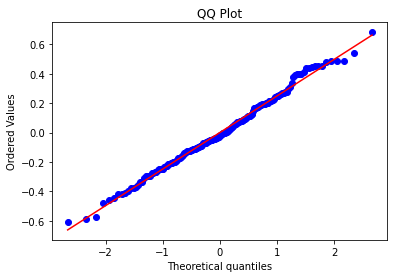

In [8]:
# QQPlot
scs.probplot(model_resid, dist='norm', plot=plt)
plt.title('QQ Plot')
plt.show()

#### Homocedasticity
The residuals must be homogeneous. And if we think it logically, that makes a lot of sense. I mean, if we’re analyzing data for a linear relationship and I want to show that Y increases as X and Z increases, then it becomes clear that the errors will be within a certain range. The errors should not be too far from the line, otherwise we’re not talking about a good linear relationship.

In [9]:
# Ho = Homocedasticity = P > 0.05
# Ha = There's no homocedasticity = p <=0.05
# Homocedasticity test
stat, p, f, fp = sms.het_breuschpagan(model_resid, model.model.exog)
print(f'Test stat: {stat}')
print(f'p-Value: {p}')
print(f'F-Value: {f}')
print(f'f_p_value: {fp}')

Test stat: 14.254047656267296
p-Value: 0.16171589669143943
F-Value: 1.4537311759619485
f_p_value: 0.16108656286703804


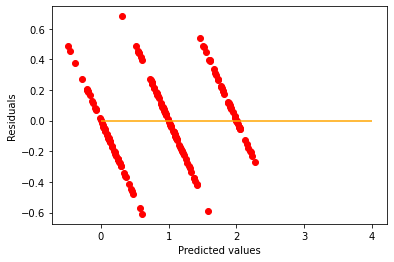

In [10]:
plt.scatter(y= model_resid, x=model.predict(), color='red')
plt.hlines(y=0, xmin=0, xmax=4, color='orange')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

#### Outliers Test
Along with the last test, another good test is the presence of outliers in the residuals. That test will help us to determine if there is any spots where our model is not being able to give a sensate result. It confirms the quality of the model. It is recommended that the numbers are between -3 and 3 or even -5 and 5.

In [11]:
# Outliers test
outliers = model.outlier_test()
print(outliers.max())
print(outliers.min())

student_resid    3.254315
unadj_p          0.999499
bonf(p)          1.000000
dtype: float64
student_resid   -2.460243
unadj_p          0.001377
bonf(p)          0.245188
dtype: float64


#### Residuals Independence
The independence of the residuals means that the observations are independent as well. So the measurement of something on a moment t1 does not influence the measurement on a moment t2.
Here, the closer the statistic of the test is to 2, the better. It means that the correlation (r) is near zero and, when plugged in this formula 2 x (1-r) it will give us 2 as result.

In [12]:
print( f'Test stat: {durbin_watson(model_resid)}')

Test stat: 1.5212847896408193


#### Multicollinearity
Multicollinearity can mess up a linear regression model.
When it is present, there is loss of information for the model calculating the OLS. Thus, the more multicollinearity, the less information for the model.
The problem with multicollinearity is the increase of the estimated parameters’ magnitude of their variance. That is because the presence of high levels of correlations between the independent variables makes impossible to estimate with precision the effect of each variable over the dependent variable. (FIGUEIREDO FILHO et all, 2011).

In [13]:
# check correlations
variables = df.drop('target', axis=1)
variables.corr()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,test_diluted_wines,proline
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100


You can also use the Variation Inflation Factor, as this gives you a single number to look at. It calculates the variance of a given variable influenced by the others. Rules of thumb say that the number should be below 10. Some say below 7.


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# VIF Test
vif = add_constant(variables)
pd.Series([variance_inflation_factor(vif.values, i) for i in range(vif.shape[1])], index=vif.columns)

const                   680.485185
alcohol                   2.460372
malic_acid                1.656647
ash                       2.185448
alcalinity_of_ash         2.238732
magnesium                 1.417855
total_phenols             4.334519
flavanoids                7.029350
nonflavanoid_phenols      1.796380
proanthocyanins           1.975683
color_intensity           3.026304
hue                       2.551447
test_diluted_wines        3.785473
proline                   2.823849
dtype: float64

### Model Analysis
After the model passed all of those tests, we’re now in a good shape to evaluate it’s summary. statsmodels brings a great one.

In [16]:
print( model.summary() )

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     147.6
Date:                Wed, 22 Dec 2021   Prob (F-statistic):           1.81e-77
Time:                        10:56:35   Log-Likelihood:                -3.2069
No. Observations:                 178   AIC:                             28.41
Df Residuals:                     167   BIC:                             63.41
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.4742 

Our model is good. We should look at the R-Squared to see how much of the relationship the linear equation was able to explain. It was 89%. If we want to know how well those variables chosen actually affects the target and explains variance, then we should look at R2-Adjusted, usually also used to compare models together with AIC and BIC (those last two metrics mentioned , the lower the better).

Both R2 and the adjusted R2 give you an idea of how many data points fall within the line of the regression equation. However, there is one main difference between R2 and the adjusted R2: R2 assumes that every single variable explains the variation in the dependent variable. The adjusted R2 tells you the percentage of variation explained by only the independent variables that actually affect the dependent variable.
Look at the P > |t| column which is the p-Value of each variable. It explains the statistical significance of that for the model. The ideal is to have everything under the significance level of 0.05. There are a couple there over that threshold.
We’re loosing 10% of the variance due to something. In order to improve this model, there should be a complete data exploration, feature engineering, perform transformations if needed. Well, many possibilities.